# Cat And Dog Classification

This dataset encompasses a collection of images specifically curated for the purpose of classifying between cats and dogs. It likely includes a variety of pictures featuring both cats and dogs, designed to aid in training machine learning models or algorithms for image classification tasks. These images may vary in terms of breeds, poses, backgrounds, and other characteristics relevant to distinguishing between cats and dogs. Researchers, developers, or data scientists could utilize this dataset to create and enhance classification algorithms intended to accurately identify and differentiate between images of cats and dogs.

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shubhamkore18","key":"acbc13343755053d4727ed4b83e8540a"}'}

In [5]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
 99% 537M/545M [00:05<00:00, 115MB/s] 
100% 545M/545M [00:05<00:00, 96.8MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### import libraries

In [9]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

import keras
import imageio # To read images
from PIL import Image # For image resizing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
base_folder = "/content/cat_dog"

valid_formats = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
image_files = [img for img in os.listdir(base_folder) if img.endswith(valid_formats)]

# Extract labels based on the prefix in the filenames ('cat' or 'dog')
data = []
for img in image_files:
    label = 0 if 'cat' in img else 1  # Label 0 for cat, 1 for dog
    full_path = os.path.join(base_folder, img)  # Full image path
    data.append((full_path, label))

# Create a DataFrame
df = pd.DataFrame(data, columns=["image_path", "label"])

# Shuffle the DataFrame (optional)
#df = df.sample(frac=1).reset_index(drop=True)

print(df.head())


                       image_path  label
0   /content/cat_dog/dog.8151.jpg      1
1  /content/cat_dog/dog.12210.jpg      1
2   /content/cat_dog/dog.5590.jpg      1
3   /content/cat_dog/dog.6970.jpg      1
4   /content/cat_dog/cat.1887.jpg      0


In [11]:
df.head(5)

,image_path,label
0,/content/cat_dog/dog.8151.jpg,1
1,/content/cat_dog/dog.12210.jpg,1
2,/content/cat_dog/dog.5590.jpg,1
3,/content/cat_dog/dog.6970.jpg,1
4,/content/cat_dog/cat.1887.jpg,0


In [12]:
df_csv=pd.read_csv('/content/cat_dog.csv')
df_csv

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1
...,...,...
24995,dog.12201.jpg,1
24996,dog.2893.jpg,1
24997,cat.12267.jpg,0
24998,dog.4380.jpg,1


In [13]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   25000 non-null  object
 1   labels  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


### Display a Random Image

(149, 150, 3)


<ipython-input-14-e3e0169fe07f>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imageio.imread('/content/cat_dog/cat.1000.jpg')


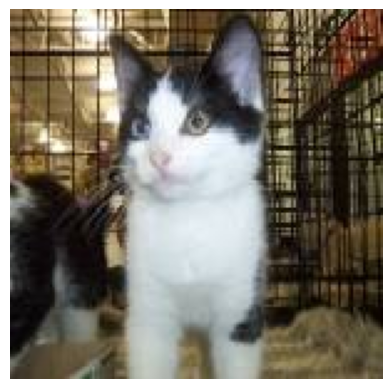

In [14]:
img=imageio.imread('/content/cat_dog/cat.1000.jpg')
plt.imshow(img)
print(img.shape)
plt.axis('off')
plt.show()

### Splitting dataset into train and test data

In [15]:
train_df, test_df = train_test_split(df_csv, test_size=0.3, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Visulizing dataset

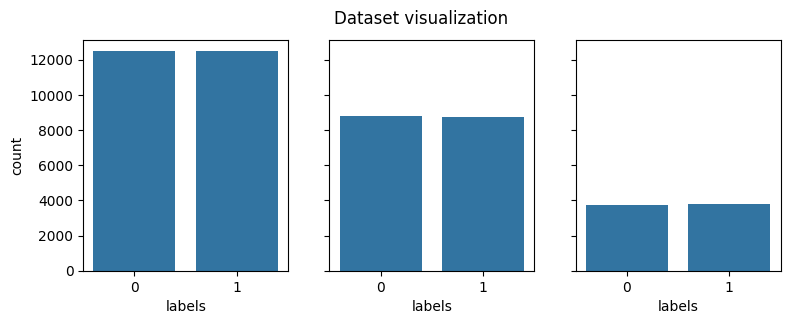

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(9, 3))
sns.countplot(x='labels',data=df_csv, ax=ax[0])
sns.countplot(x='labels',data=train_df, ax=ax[1])
sns.countplot(x='labels',data=test_df, ax=ax[2])
fig.suptitle('Dataset visualization')
plt.show()

### Reshaping images in 64*64

In [17]:
temp = []
for img_name in train_df.image:
    img_path = os.path.join("/content/cat_dog", img_name)
    img = imageio.imread(img_path)
    img = np.array(Image.fromarray(img).resize((64, 64))).astype('float32')
    temp.append(img)
train_x = np.stack(temp)

<ipython-input-17-b11c40b5b99d>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [18]:
temp = []
for img_name in test_df.image:
    img_path = os.path.join("/content/cat_dog", img_name)
    img = imageio.imread(img_path)
    img = np.array(Image.fromarray(img).resize((64, 64))).astype('float32')
    temp.append(img)
test_x = np.stack(temp)

<ipython-input-18-250dba6d0433>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


#### Normalizing the images

In [19]:
train_x = train_x / 255.
test_x = test_x / 255.

# Encoding the categorical variable to numeric
lb = LabelEncoder()
train_y = lb.fit_transform(train_df.labels)
train_y = to_categorical(train_y)

In [20]:
test_y = lb.fit_transform(test_df.labels)
test_y = to_categorical(test_y)

### Model Selection and Traning

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Model architecture
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(96, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Split data into train and validation sets
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42
)

In [23]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_x)


In [24]:
# Data augmentation for validation (usually minimal or none)
val_datagen = ImageDataGenerator()  # No augmentations for validation
val_datagen.fit(val_x)  # Important to call fit on val_datagen as well


In [25]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training
history = model.fit(datagen.flow(train_x, train_y, batch_size=32),
                    validation_data=val_datagen.flow(val_x, val_y, batch_size=32),  # Using validation set
                    epochs=50,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.5505 - loss: 5.4541 - val_accuracy: 0.5657 - val_loss: 2.1265 - learning_rate: 0.0010
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.6206 - loss: 1.7390 - val_accuracy: 0.5791 - val_loss: 1.1622 - learning_rate: 0.0010
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.6486 - loss: 1.0606 - val_accuracy: 0.6569 - val_loss: 0.8907 - learning_rate: 0.0010
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.6556 - loss: 0.8902 - val_accuracy: 0.6883 - val_loss: 0.8483 - learning_rate: 0.0010
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.6581 - loss: 0.8728 - val_accuracy: 0.6837 - val_loss: 0.8815 - learning_rate: 0.0010
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6735 - loss: 0.8884 - val_accuracy: 0.7077 - val_loss: 0.8842 - learning_rate: 0.0010
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.6771 - loss: 0.9423

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_x,test_y, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8828 - loss: 0.3946
Test Loss: 0.38460108637809753
Test Accuracy: 0.8853333592414856


In [27]:
# Make predictions
predictions = model.predict(test_x)

# Convert predictions to class labels (e.g., for a binary classification problem)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_y, axis=1)


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


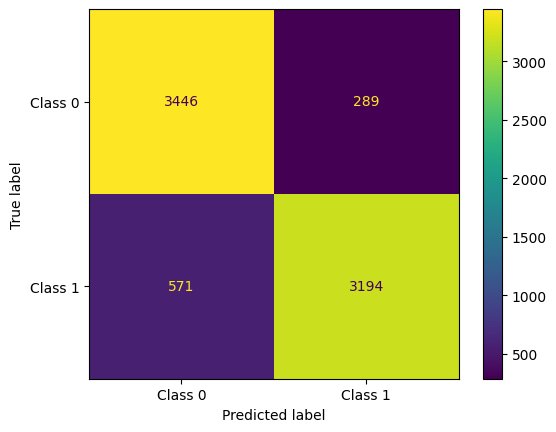

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='viridis')
plt.show()


In [29]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=['Class 0', 'Class 1']))


              precision    recall  f1-score   support

     Class 0       0.86      0.92      0.89      3735
     Class 1       0.92      0.85      0.88      3765

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



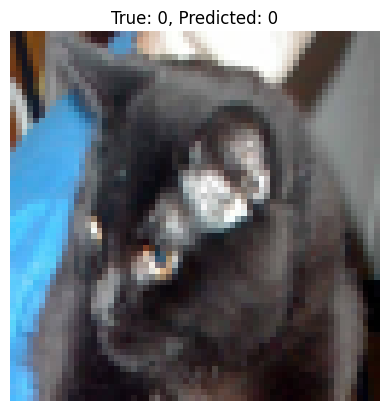

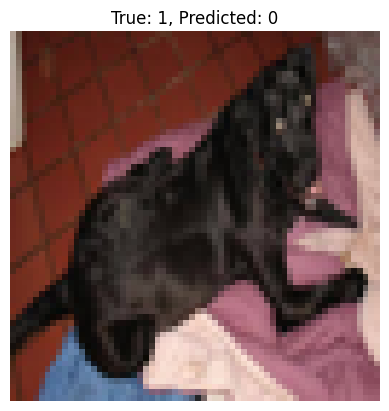

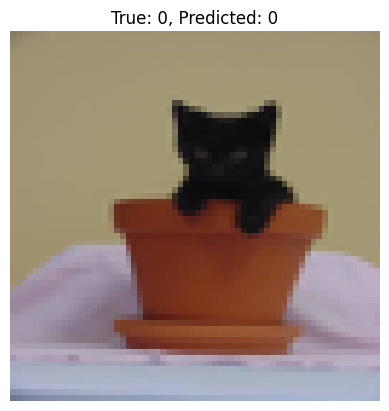

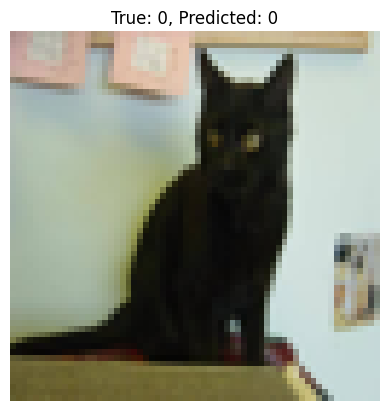

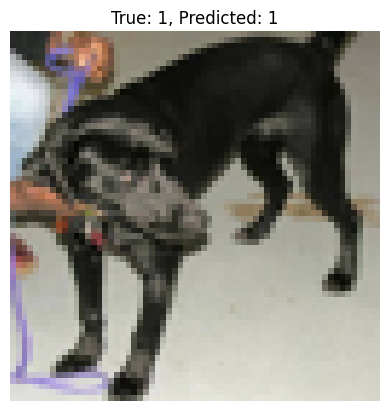

In [30]:
# Display some predictions
for i in range(5):  # Display first 5 test images
    plt.imshow(test_x[i].reshape(64, 64, 3))  # Reshape to original image size
    plt.title(f"True: {true_classes[i]}, Predicted: {predicted_classes[i]}")
    plt.axis('off')
    plt.show()


In [31]:
model.save('model.h5')  # Save the trained model

#Use pretrained model MobileNet

In [41]:
from tensorflow.keras.applications import MobileNetV2

In [43]:
# Use MobileNetV2 for transfer learning
base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Build the model
model2 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    Dropout(0.6),
    Dense(2, activation='softmax')
])

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model2.fit(
    datagen.flow(train_x, train_y, batch_size=32),
    validation_data=val_datagen.flow(val_x, val_y, batch_size=32),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)



<ipython-input-43-3040030ddf3e>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')


Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.4856 - loss: 3.6580 - val_accuracy: 0.4889 - val_loss: 1.1501 - learning_rate: 1.0000e-04
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.5132 - loss: 1.0288 - val_accuracy: 0.4974 - val_loss: 1.0156 - learning_rate: 1.0000e-04
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.5071 - loss: 0.9352 - val_accuracy: 0.4946 - val_loss: 0.9413 - learning_rate: 1.0000e-04
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.5029 - loss: 0.8754 - val_accuracy: 0.4997 - val_loss: 0.8890 - learning_rate: 1.0000e-04
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4973 - loss: 0.8304 - val_accuracy: 0.5020 - val_loss: 0.8467 - learning_rate: 1.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [44]:
# Evaluate the model on the test set
test_loss, test_accuracy =model2.evaluate(test_x,test_y, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4916 - loss: 1.1399
Test Loss: 1.1401807069778442
Test Accuracy: 0.492000013589859


In [37]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model with pretrained ImageNet weights
base_model = VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the model
model4 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: cat and dog
])

# Compile the model
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model4.fit(
    datagen.flow(train_x, train_y, batch_size=32),
    validation_data=val_datagen.flow(val_x, val_y, batch_size=32),
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.5110 - loss: 3.5851 - val_accuracy: 0.5477 - val_loss: 1.1723 - learning_rate: 1.0000e-04
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.4989 - loss: 1.0524 - val_accuracy: 0.5386 - val_loss: 0.8632 - learning_rate: 1.0000e-04
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.4945 - loss: 0.8486 - val_accuracy: 0.5271 - val_loss: 0.7981 - learning_rate: 1.0000e-04
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.4928 - loss: 0.7907 - val_accuracy: 0.5206 - val_loss: 0.7633 - learning_rate: 1.0000e-04
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.5020 - loss: 0.7569 - val_accuracy: 0.5257 - val_loss: 0.7355 - learning_rate: 1.0000e-04
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.5059 - loss: 0.7360 - val_accuracy: 0.5134 - val_loss: 0.7252 - learning_rate: 1.0000e-04
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accurac

In [39]:
# Evaluate the model on the test set
test_loss, test_accuracy =model4.evaluate(test_x,test_y, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5013 - loss: 0.6931
Test Loss: 0.6931045055389404
Test Accuracy: 0.5019999742507935
